# Trotterization with light-cone (short-time)

In [1]:
from functools import partial
from qiskit.quantum_info import SparsePauliOp, random_statevector
import multiprocessing

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy
import jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
# from lightcone import *
from spin_ham import *
from trotter import *
from bounds import *
# from noise import *

figs_dir, data_dir = './figs', './data'

## Nearest-neighbor Heisenberg 

In [2]:


h_test = Nearest_Neighbour_1d(6, Jx=1, Jy=1, Jz=1, hx=1, hy=0, hz=0, pbc=False, verbose=False)
h_test_list = lc_group(h_test, 0, 0, 6, False)
print(h_test_list)
cmm_1_test = commutator(h_test_list[1], commutator(h_test_list[1], h_test_list[0]).simplify()).simplify()
cmm_2_test = commutator(h_test_list[0], commutator(h_test_list[0], h_test_list[1]).simplify()).simplify()
print(np.linalg.norm(cmm_1_test.coeffs, ord=1))
print(np.linalg.norm(cmm_2_test.coeffs, ord=1))

[SparsePauliOp(['IIIIIX', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIXII', 'IXXIII', 'IYYIII', 'IZZIII', 'IXIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), SparsePauliOp(['IIIIXX', 'IIIIYY', 'IIIIZZ', 'IIIIXI', 'IIXXII', 'IIYYII', 'IIZZII', 'IIXIII', 'XXIIII', 'YYIIII', 'ZZIIII', 'XIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j]), SparsePauliOp(['IIIIII'],
              coeffs=[0.+0.j])]
600.0
488.0


In [3]:
from bounds import *
# Create a pool of processes
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-2)

# Apply the process_data function to each index in parallel
results = pool.map(process_data, range(1, 4000-1))

# Close the pool of processes
pool.close()
pool.join()
print(results)

1 0.24200826045591906
2 0.6483616263296527
3 1.2907281681710367
4 2.856467917218185
5 2.987989439755173
6 3.2603656190599164
7 3.762376358888369
8 4.368712996092663
9 5.676817094744431
10 6.133821529534046
11 7.653325230953013
12 7.729864086160195
13 7.6436289890934335
14 8.434872999421033
15 8.479868581928882
16 10.220574770782758
17 10.530699294302746
18 10.451569877389085
19 11.412930219309992
20 12.312624110064556
21 12.782872652917261
22 13.88946957959194
23 15.743505400397796
24 14.448522743732319
25 16.36230153168708
113 26 15.900244038456092
64.3802480306869
27 17.410190467534928
28 17.947400917319094
29 17.118736366070028
30 19.046358964469665
31 19.220931630453123
32 18.67975514643491
225 124.38465634931899
33 19.731222022879713
34 20.48520048779678
35 21.721499665753555
36 22.19340769872591
37 21.634820701523577
38 23.490598666430923
39 23.89889175208547
114 65.93357259024926
40 23.661774725967557
41 24.802103643036766
42 24.606913229174808
43 24.453205839920198
44 27.070196

In [13]:
def my_function(x):
    # Your custom function logic here
    return np.linalg.norm(np.random.rand(5000, 5000), ord=1)  # Example function: squaring each element

import jax
import numpy as np
import jax.numpy as jnp
# Create a vectorized version of the function
# vectorized_function = np.vectorize(my_function)
vectorized_function = jax.vmap(my_function)

res = vectorized_function(jnp.arange(1, 3000000000))
print(len(res), res)
# vectorized_function(np.arange(1, 10000))

2999999999 [2572.3767 2572.3767 2572.3767 ... 2572.3767 2572.3767 2572.3767]


In [24]:
prefix, suffix = 'NNH', 'n'
cmm_data = dict([('n', []), ('c1', []), ('c2', [])])
tail_cmm_data = dict([('n', []), ('c1_z', []), ('c2_z', []), ('c1_zz', []), ('c2_zz', [])])
n_bnd_max = 100
n_list = np.arange(1, n_bnd_max)
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 30, 40, 49]
n_list_bnd = [5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21, 25, 30, 40, 54, 70, 94]
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 30, 40, 54, 70, 94, 124, 164, 216, 286, 378, 499]
tail_cmm_data['n'] = n_list
cmm_data['n'] = n_list
# r_max = int(n_bnd_max * 0.5) + 1
r_max = n_bnd_max
# J, h = 0.2, 0.2
# J, h = 1, 1
J, h = 1, 0.3
field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
for n in n_list:
    # if n % int(len(n_list)/3) ==0: print(' n = ', n)
    # else: print('+', end='')

    if n in n_list_bnd:
        print(f'n={n}--->r', end='')
        hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list, verbose=False)
        # field_list = hnn.rand_field
        # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
        h_list = hnn.ham_par
        # c1_cmm = commutator(h_list[1], commutator(h_list[1], h_list[0]).simplify()).simplify()
        c1_cmm, c2_cmm = nested_commutator_norm(h_list) 
        cmm_data['c1'].append(c1_cmm)
        cmm_data['c2'].append(c2_cmm)
        # cmm_data['c1'].append(np.linalg.norm(c1_cmm.coeffs, ord=1))
        temp_n_1_z, temp_n_2_z, temp_n_1_zz, temp_n_2_zz = [], [], [], []
        for r in range(1, r_max):
            print('+', end='')
            # temp_r_1_z, temp_r_2_z, temp_r_1_zz, temp_r_2_zz = [], [], [], []
            # for i in range(0, n-1):
            #     h_list_z  = lc_group(hnn, i, i, 2*r, False)
            #     c1_cmm_z, c2_cmm_z = nested_commutator_norm(h_list_z) 
            #     # h_list = hnn.ham_par
            #     # c1_cmm_z_1 = commutator(h_list_z[1]+h_list_z[2], commutator(h_list_z[1]+h_list_z[2], h_list_z[0]).simplify()).simplify() 
            #     temp_r_1_z.append(c1_cmm_z)
            #     temp_r_2_z.append(c2_cmm_z)

            #     h_list_zz = lc_group(hnn, i, i+1, 2*r, False)
            #     c1_cmm_zz, c2_cmm_zz = nested_commutator_norm(h_list_zz) 
            #     temp_r_1_zz.append(c1_cmm_zz)
            #     temp_r_2_zz.append(c2_cmm_zz)

            # Create a pool of processes
            # pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-1)

            # # Apply the process_data function to each index in parallel
            # results = pool.map(partial(lc_nested_commutator_norm, h=hnn, r=r), range(0, n-1))

            # # Close the pool of processes
            # pool.close()
            # pool.join()
            results = [lc_nested_commutator_norm(i, hnn, r) for i in range(0, n-1)]
            # vectorized_function = jax.vmap(partial(lc_nested_commutator_norm, h=hnn, r=r))
            # results = vectorized_function(jnp.arange(0, n-1))

            # Separate the results into individual lists
            temp_r_1_z, temp_r_2_z, temp_r_1_zz, temp_r_2_zz = zip(*results)

            temp_n_1_z.append(temp_r_1_z)
            temp_n_2_z.append(temp_r_2_z)
            temp_n_1_zz.append(temp_r_1_zz)
            temp_n_2_zz.append(temp_r_2_zz)
        tail_cmm_data['c1_z'].append(temp_n_1_z)
        tail_cmm_data['c2_z'].append(temp_n_2_z)
        tail_cmm_data['c1_zz'].append(temp_n_1_zz)
        tail_cmm_data['c2_zz'].append(temp_n_2_zz)
        # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
        # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
        # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
        print('')
    else:
        cmm_data['c1'].append([])
        cmm_data['c2'].append([])
        tail_cmm_data['c1_z'].append([])
        tail_cmm_data['c2_z'].append([])
        tail_cmm_data['c1_zz'].append([])
        tail_cmm_data['c2_zz'].append([])

pd.DataFrame(cmm_data).to_csv(f'{data_dir}/{prefix}_nested_commutator_norm_J={J}_h={h}_max={n_bnd_max}_{suffix}.csv', index=False)
print(pd.DataFrame(cmm_data))

# save tail_cmm_data to npy file
np.save(f'{data_dir}/{prefix}_tail_nested_commutator_norm_J={J}_h={h}_max={n_bnd_max}_{suffix}.npy', tail_cmm_data)
print(tail_cmm_data)

n=5---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=6---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=7---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=8---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=9---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=10---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=11---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=12---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=15---> +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
n=18---> +++++++++++++++

In [45]:
print(tail_cmm_data['c1_z'][5][2][0]+tail_cmm_data['c2_z'][5][2][0]/2)
print(tail_cmm_data['c1_zz'][5][2][0]+tail_cmm_data['c2_zz'][5][2][0]/2)
# print(sum(tail_cmm_data['c1_zz'][5][5])/5+sum(tail_cmm_data['c2_zz'][5][5])/10)

844.0
752.0


In [4]:
# demo of the nearest-neighbor Hamiltonian
# hnn = Nearest_Neighbour_1d(3, Jx=2, Jy=2, Jz=2, hx=0, hy=0, hz=1, pbc=False, verbose=True)
# prefix, suffix = 'TFI', 'n'
prefix, suffix = 'NNH', 'n'
cmm_data = dict([('n', []), ('c1', []), ('c2', [])])
n_bnd_max = 160
n_list = np.arange(1, n_bnd_max)
field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
cmm_data['n'] = n_list
# J, h = 0.2, 0.2
J, h = 1, 0.3
for n in n_list:
    if n % int(len(n_list)/3) ==0: print(' n = ', n)
    else: print('+', end='')
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    h_list = hnn.ham_par
    # h_list = hnn.ham_par
    c1_cmm = commutator(h_list[1], commutator(h_list[1], h_list[0]).simplify()).simplify()
    c2_cmm = commutator(h_list[0], commutator(h_list[0], h_list[1]).simplify()).simplify()
    cmm_data['c1'].append(np.linalg.norm(c1_cmm.coeffs, ord=1))
    cmm_data['c2'].append(np.linalg.norm(c2_cmm.coeffs, ord=1))
pd.DataFrame(cmm_data).to_csv(f'{data_dir}/{prefix}_nested_commutator_norm_J={J}_h={h}_max={n_bnd_max}_{suffix}.csv', index=False)
pd.DataFrame(cmm_data)

++++++++++++++++++++++++++++++++++++++++++++++++++++ n =  53
++++++++++++++++++++++++++++++++++++++++++++++++++++ n =  106
++++++++++++++++++++++++++++++++++++++++++++++++++++ n =  159


n            c1            c2
0      1      0.000000      0.000000
1      2      0.969920      6.451394
2      3     64.408453     62.188275
3      4    124.297063    219.608681
4      5    284.762001    277.716782
..   ...           ...           ...
154  155  16585.994525  16604.370501
155  156  16642.674697  16760.352486
156  157  16799.909882  16817.988256
157  158  16857.033265  16975.868336
158  159  17015.005284  17034.144962

[159 rows x 3 columns]

In [46]:
r, n  = 2, 8
# r, n, J, h, t = 1, 8, 1, 0.2, 0.5
measure_error(r, h_list, t, exact_U, type='lightcone_bound', coeffs=['singl', n, cmm_data])
# relaxed_lc_bound(r, n, cmm_data, t, ob_type='singl', verbose=True)
# relaxed_commutator_bound(2, cmm_data, 1, True) 

0.017062499999999998

In [53]:
r = 1
err_bound = 0
for i in range(1, r+1):
    n_lc = min(i*2, n)
    err_bound += 2 * relaxed_commutator_bound(n_lc, cmm_data, t/r) 
    print(err_bound)

0.0022500000000000003


In [7]:
print(tail_cmm_data)

{'n': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'c1_z': [[], [], [], [], [[272.87727734902376, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.4046017096297, 283.5667049191882], [278.3084466764303, 282.2638464598909, 230.404

In [4]:
np.logspace(1, 2.3, 15, dtype=int)

array([ 10,  12,  15,  18,  23,  29,  36,  44,  55,  68,  84, 105, 130,
       161, 199])

In [47]:
test_list = [[1, 2], [4, 5], [7, 8]]
a = np.array(test_list)
sum(a[:, 1])

15

In [4]:
# prefix, suffix = 'TFI', 'n'
prefix, suffix = 'NNH', 'n'
use_jax = True
n_bnd_max = 200 # 400
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84]
n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 199]
# n_bnd_max = 200 # 400
r_max = n_bnd_max
# n_max, n_min = 9, 5
n_max, n_min = 12, 5
t = 0.2
# J, h = 1, 0.2
# J, h = 0.2, 0.2
# J, h = 1, 1
J, h = 1, 0.3
field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
# print('random field: ', field_list)
# field_list = [random.gauss(0, 0.1)]
# read cmm_data from npy file
# tail_cmm_data = np.load(f'{data_dir}/{prefix}_tail_nested_commutator_norm_J={J}_h={h}_max={n_bnd_max}_{suffix}.npy', allow_pickle=True).item()
# print(tail_cmm_data['c1_z'][1][3])
# cmm_data = pd.read_csv(f'{data_dir}/{prefix}_nested_commutator_norm_J={J}_h={h}_max={n_bnd_max}_{suffix}.csv')
eps = 0.005 # 1e-3
# n_list_bnd = [4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20,  26,  33,  42,  54,  69,  88, 112, 142, 181, 231, 295]
# n_list_bnd = [4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 30, 40, 54, 70, 94, 124, 164, 216, 286, 378, 499]
# n_list_bnd = [n_min, 6, 7, 8, 9, 10, 12, 15, 18]
# n_list_bnd = [n_min, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 29]
# n_list_bnd = [n_min, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 30, 40]
# n_list_bnd = [n_min, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 30, 40, 49]
# n_list_bnd = n_list
# n_list_bnd = [n_min, 6, 7, 8, 9, 10, 12, 15, 18, 21, 25, 30, 40, 54, 70, 94, 124, 164, 216, 286, 378]
n_list_emp = np.arange(n_min, n_max+1)
print('n_list_emp: ', n_list_emp)

data_keys = ['worst', 'singl', 'multi', 'n']
bnd_data = dict([(k, []) for k in data_keys])
emp_data = dict([(k, []) for k in data_keys])
bnd_data['n'], emp_data['n'] = n_list_bnd, n_list_emp

r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd, r_end = 1, 1, 1, r_max-1
for i, n in enumerate(n_list_bnd):
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    # r_start, r_end = 1, int(n/2)
    print(f'-------------- n (bound) = {n} --------------')
    bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, hnn])
    # bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, tail_cmm_data])
    bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn])
    bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['multi_zz', n, hnn])

    r_worst_bnd = binary_search_r(r_start_worst_bnd, r_end, eps, bnd_worst_err_r, verbose=True)
    r_singl_bnd = binary_search_r(r_start_singl_bnd, r_end, eps, bnd_singl_err_r, verbose=True)
    r_multi_bnd = binary_search_r(r_start_multi_bnd, r_end, eps, bnd_multi_err_r, verbose=True)
    bnd_data['worst'].append(r_worst_bnd)
    bnd_data['singl'].append(r_singl_bnd)
    bnd_data['multi'].append(r_multi_bnd)
    r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = r_worst_bnd, r_singl_bnd, r_multi_bnd

r_start_worst_emp, r_start_singl_emp, r_start_multi_emp, r_end = 1, 1, 1, r_max-1
for n in n_list_emp:
    print(f'-------------- n (empirical) = {n} --------------')
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    # field_list = hnn.rand_field
    singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Y', [i], 1) for i in range(0, n)], n).to_matrix()
    multi_ob = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([(random.choice(['X','Y','Z']), [i], 1) for i in range(0, n)], n).to_matrix()
    print('multi ob norm: ', np.linalg.norm(multi_ob, ord=2))
    multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
    par_group = [h.to_matrix() for h in hnn.ham_par]
    # par_group = [h.to_matrix() for h in hnn.ham_par][::-1]
    xyz_group = [h.to_matrix() for h in hnn.ham_xyz]

    exact_U = jax.scipy.linalg.expm(-1j * t * sum([h for h in par_group]))
    # verfiy the exact_U
    assert np.allclose(exact_U, jax.scipy.linalg.expm(-1j * t * sum([h for h in xyz_group])))

    emp_worst_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical', use_jax=use_jax)
    emp_singl_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=singl_ob, type='worst_ob_empirical', use_jax=use_jax)
    emp_multi_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=multi_ob, type='worst_ob_empirical', use_jax=use_jax)

    r_worst_emp = binary_search_r(r_start_worst_emp, r_end, eps, emp_worst_err_r, verbose=True)
    r_singl_emp = binary_search_r(r_start_singl_emp, r_end, eps, emp_singl_err_r, verbose=True)
    r_multi_emp = binary_search_r(r_start_multi_emp, r_end, eps, emp_multi_err_r, verbose=True)
    emp_data['worst'].append(r_worst_emp)
    emp_data['singl'].append(r_singl_emp)
    emp_data['multi'].append(r_multi_emp)
    r_start_worst_emp, r_start_singl_emp, r_start_multi_emp = r_worst_emp, r_singl_emp, r_multi_emp

print('emp_data: ', emp_data)
# print(pd.DataFrame(emp_data))
# save to csv
pd.DataFrame(emp_data).to_csv(f'{data_dir}/{prefix}_emp_lightcone_max={n_max}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data).to_csv(f'{data_dir}/{prefix}_bnd_lightcone_max={n_max}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data)

n_list_emp:  [ 5  6  7  8  9 10 11 12]
-------------- n (bound) = 5 --------------
----binary search r (r_start=1, r_end=199)----
r_start: 1 ; r_end: 100
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 7 ; r_end: 13
r_start: 10 ; r_end: 13
r_start: 10 ; r_end: 11
r: 11 ; err:  0.004648852519010889
----binary search r (r_start=1, r_end=199)----
r_start: 1 ; r_end: 100
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 4 ; r_end: 7
r_start: 4 ; r_end: 5
r: 5 ; err:  0.004519784808607003
----binary search r (r_start=1, r_end=199)----
r_start: 1 ; r_end: 100
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 4 ; r_end: 7
r_start: 4 ; r_end: 5
r: 5 ; err:  0.004386458141297919
-------------- n (bound) = 6 --------------
----binary search r (r_start=11, r_end=199)----
r_start: 11 ; r_end: 105
r_start: 11 ; r_end: 58
r_start: 11 ; r_end: 34
r_start: 11 ; r_end: 22
r_

worst  singl  multi    n
0      11      5      5    5
1      13      6      6    6
2      15      6      6    7
3      16      7      7    8
4      17      7      7    9
5      19      7      7   10
6      21      8      8   12
7      24      9      9   15
8      26      9      9   18
9      30     10     10   23
10     35     10     11   29
11     39     10     11   36
12     43     10     12   44
13     48     10     12   55
14     54     10     13   68
15     60     10     13   84
16     67     10     13  105
17     75     10     13  130
18     84     10     13  161
19     93     10     13  199

a_em: 1.5455549666810227; b_em: 3.755692284718266
a_em: 2.3869676440577203e-08; b_em: 6.7569322797544045
a_em: 1.0530623216112622; b_em: 4.383357552293857
a_em: -4.922715389657722e-08; b_em: 4.499809785921908
a_em: 1.0000000000000007; b_em: 3.4657359027997248


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


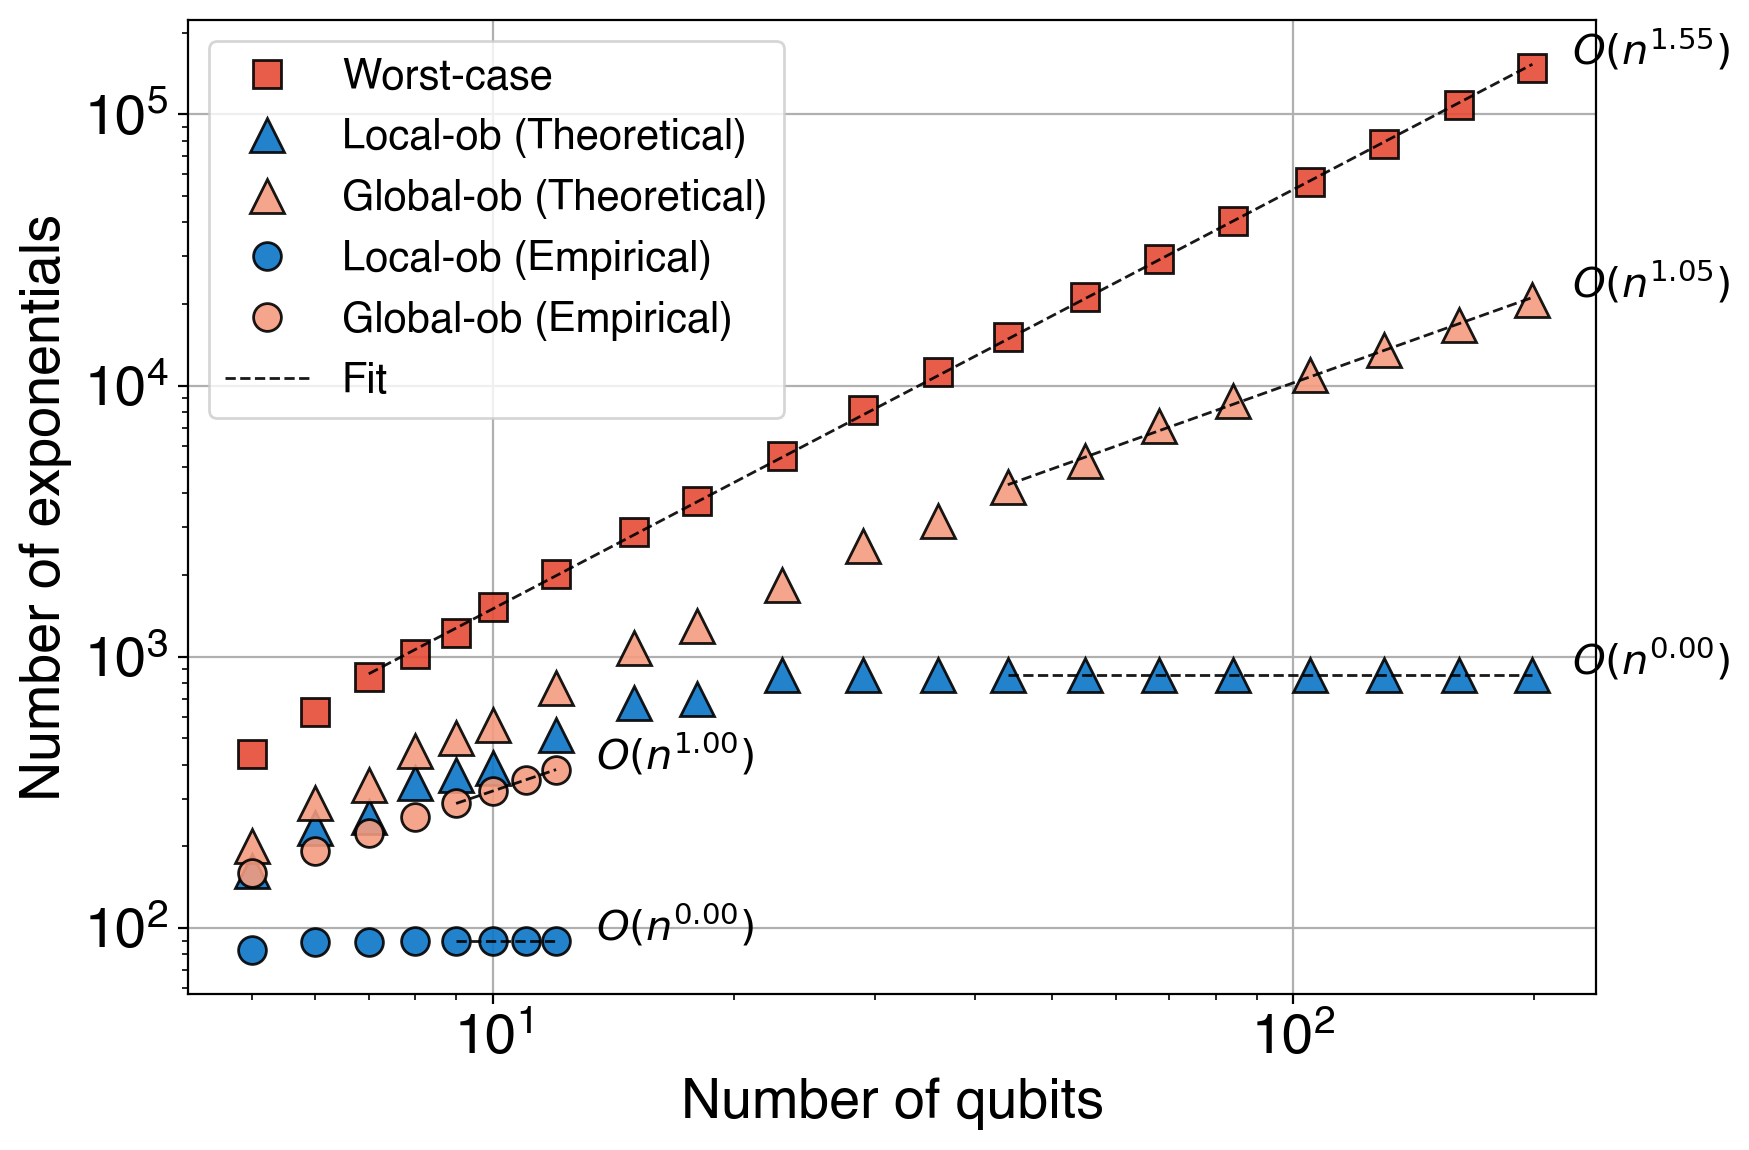

In [5]:
if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

def exp_count_LC(r, n_qubits, n_terms):
    exp_count = 0
    for i in range(1, r+1):
        # print('i: ', i)
        if i < int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2    
            # exp_count += (4 * i - 1) * 2    
        elif i == int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2  - 1
        else:
            exp_count += n_terms * 2
    return exp_count

cost_st_list = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['worst'])]
cost_lc_list_s = [exp_count_LC(r, bnd_data['n'][i], factor*bnd_data['n'][i]) for i, r in enumerate(bnd_data['singl'])]
cost_lc_list_m = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['multi'])]
cost_em_list_s = [exp_count_LC(r, emp_data['n'][i], factor*emp_data['n'][i]) for i, r in enumerate(emp_data['singl'])]
cost_em_list_m =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['multi'])]

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
# ob_string = 'XIII'
ax2.plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case', markersize=10)
plot_fit(ax2, n_list_bnd[2:], cost_st_list[2:], var=suffix, x_offset=1.12)
# # ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list_bnd, cost_lc_list_s, '^', color='#0A75C7', label='Local-ob (Theoretical)', markersize=12)
plot_fit(ax2, n_list_bnd[-8:], cost_lc_list_s[-8:], var=suffix, x_offset=1.12)
ax2.plot(n_list_bnd, cost_lc_list_m, '^', color='#F39B7FFF', label='Global-ob (Theoretical)', markersize=12)
plot_fit(ax2, n_list_bnd[-8:], cost_lc_list_m[-8:], var=suffix, x_offset=1.12)
# plot_fit(ax2, n_list_bnd[2:9], cost_lc_list_m[2:9], var=suffix, x_offset=1.06, y_offset=0.8)
ax2.plot(n_list_emp, cost_em_list_s, 'o', color='#0A75C7', label='Local-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.12)
ax2.plot(n_list_emp, cost_em_list_m, 'o', color='#F39B7FFF', label='Global-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.12, label='Fit')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
ax2.loglog(); ax2.grid(); ax2.legend(loc='upper left')
fig.savefig(f'{figs_dir}/lightcone_NNH1d_J={J}_h={h}_n={n}_eps={eps}_t={t}.pdf', bbox_inches='tight')

In [ ]:
n_list = [4, 5, 6, 7, 8, 9, 10, 12, 14,  18,  24,  30,  40,  54,  70,  94, 124, 164, 216, 286, 378, 500]
n_list_emp = range(4, 10, 1)
# st_r_bound_n, st_cost_bound_n, lc_r_bound_n, lc_cost_bound_n, em_r_bound_n, em_cost_bound_n = [], [], [], [], [], []
ob_index = [0]
# t = 1.0
t = 0.5
J=1; h=0.2
# J=1/2; h=1/2
ob_type = 'multi'
epsilon=0.005; search_precision=0.02
r_st_found_list, r_lc_found_list, cost_st_found_list, cost_lc_found_list, r_em_found_list, cost_em_found_list = [], [], [], [], [], []
r_lc_found_list_s, cost_lc_found_list_s, r_em_found_list_s, cost_em_found_list_s = [], [], [], []
for n in n_list:
    print(f'--------------------------n={n}----------------------------')
    # ob, ob_dict = local_ob(ob_index, n)
    # ising1d_n_bd = transverse_field_ising_1d(n, J, h, ob_index, t=t, initialize=True, verbose=verbose)
    # print(ising1d_n_bd.all_terms)
    # print(2 * tight_bound([h.to_matrix() for h in ising1d_n_bd.all_terms], 2, t, 1))
    # print('========== STANDARD Bound ==========')
    r_list_st, error_list_st, exp_count_list_st, r_found_st, r_err_dict_st = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='standard', ob_type='multi', verbose=True)
    r_list_lc, error_list_lc, exp_count_list_lc, r_found_lc, r_err_dict_lc = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='lightcone', ob_type='multi', verbose=True)
    print(f'standard: error={r_err_dict_st[r_found_st]:.6f}; exp_count={ 2 * n * r_found_st}')
    print(f'lightcone: error={r_err_dict_lc[r_found_lc]:.6f}; exp_count={exp_count_LC(r_found_lc, n, 2*n)}')
    r_st_found_list.append(r_found_st)
    r_lc_found_list.append(r_found_lc)
    cost_st_found_list.append(2 * (2*n) * r_found_st)
    cost_lc_found_list.append(2 * (2*n) * r_found_lc)

    # print('========== LIGHTCONE Bound ==========')
    r_list_lc_s, error_list_lc_s, exp_count_list_lc_s, r_found_lc_s, r_err_dict_lc_s = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='lightcone', verbose=True)
    print(f'lightcone: error={r_err_dict_lc_s[r_found_lc_s]:.6f}; exp_count={exp_count_LC(r_found_lc_s, n, 2*n)}')
    r_lc_found_list_s.append(r_found_lc_s)
    cost_lc_found_list_s.append(exp_count_LC(r_found_lc_s, n, 2*n))
    # cost_lc_found_list.append(exp_count_LC(r_found_lc, n, 2*n))

    # _, _, _, r_bound = binary_search_r(ising1d_n, ob, t, epsilon, search_precision, type='bound', verbose=True)
    # st_r_bound_n.append(r_bound)
    # st_cost_bound_n.append(r_bound*2*ising1d_n.n_terms)
for n in n_list_emp:
    print(f'========== EMPIRICAL n={n}==========')
    r_list_em, error_list_em, exp_count_list_em, r_found_em, r_err_dict_em = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='empirical', ob_type='multi', verbose=True)
    print(f'empirical: error={r_err_dict_em[r_found_em]:.6f}; exp_count={ 2 * n * r_found_em}')
    r_em_found_list.append(r_found_em)
    cost_em_found_list.append(2 * (2*n) * r_found_em)

    r_list_em_s, error_list_em_s, exp_count_list_em_s, r_found_em_s, r_err_dict_em_s = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='empirical', ob_type='single', verbose=True)
    # print(f'empirical: error={r_err_dict_em[r_found_em]:.6f}; exp_count={ 2 * n * r_found_em}')
    # r_em_found_list.append(r_found_em)
    # cost_em_found_list.append(2 * (2*n) * r_found_em)
    cost_em_found_list_s.append(exp_count_LC(r_found_em, n, 2*n))
    # cost_em_found_list_s.append(exp_count_list_em_s[-1])

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
ob_string = 'XIII'
ax2.plot(n_list, cost_st_found_list, 's', color='#E64B35FF', label=r'Worst-case', markersize=10)
# ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list, cost_lc_found_list_s, '^', color='#0A75C7', label='Single-ob (Theoretical)', markersize=12)
ax2.plot(n_list, cost_lc_found_list, '^', color='#F39B7FFF', label='Multip-ob (Theoretical)', markersize=12)
ax2.plot(n_list_emp, cost_em_found_list_s, 'o', color='#0A75C7', label='Single-ob (Empirical)')
ax2.plot(n_list_emp, cost_em_found_list, 'o', color='#F39B7FFF', label='Multip-ob (Empirical)')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'ob=$\sum Z_j/n$, TFI (fix t={t}, $\epsilon$={epsilon}) PF2')  

ax2.xaxis.set_major_formatter(formatter)
# ax2.set_yscale('log')
# ax2.set_xscale('log')

y_pred_st, a_st, b_st = linear_loglog_fit(n_list, cost_st_found_list)
ax2.plot(n_list, y_pred_st, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % str(a_st)[:4], xy=(n_list[-1], np.real(y_pred_st)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_st)[-1]+1))

perc= 3/2.0
# perc= 3/2.2
# perc= 3/2.5
print(n_list[int(len(n_list)/perc)])
y_pred_lc, a_lc, b_lc = linear_loglog_fit(n_list[int(len(n_list)/perc):], cost_lc_found_list[int(len(n_list)/perc):])
ax2.plot(n_list[int(len(n_list)/perc):], y_pred_lc, 'k--', label='Fit', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % str(a_lc)[:4], xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))

# multip-ob empirical
y_pred_em, a_em, b_em = linear_loglog_fit(n_list_emp, cost_em_found_list)
print(f'a_em: {a_em}; b_em: {b_em}')
text_a_em = "{:.2f}".format(round(abs(a_em), 4))
y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in n_list])+b_em]
ax2.plot(n_list, y_pred_em, 'k--', linewidth=1)
# ax2.plot(n_list_emp, y_pred_em, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % text_a_em, xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))

# single-ob empirical
y_pred_em, a_em, b_em = linear_loglog_fit(n_list_emp[3:], cost_em_found_list_s[3:])
print(f'a_em: {a_em}; b_em: {b_em}')
text_a_em = "{:.2f}".format(round(abs(a_em), 4))
y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in n_list])+b_em]
ax2.plot(n_list[2:], y_pred_em[2:], 'k--', linewidth=1)
# ax2.plot(n_list_emp, y_pred_em, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % text_a_em, xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))
# ax2.annotate(r'$O(n^{%s})$' % str(round(abs(a_em), 4))[:4], xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))

# single-ob bound
perc= 3
y_pred_lc, a_lc, b_lc = linear_loglog_fit(n_list[int(len(n_list)/perc):], cost_lc_found_list_s[int(len(n_list)/perc):])
text_a_lc = "{:.2f}".format(round(abs(a_lc), 4))
ax2.plot(n_list[int(len(n_list)/perc):], y_pred_lc, 'k--', linewidth=1)
# ax2.annotate(r'$O(n^{%s})$' % text_a_lc, xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))
ax2.annotate(r'$O(n^{%s})$' % text_a_lc, xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))
# ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.loglog()

# ax2.set_xticks(range(int(min(n_list)), int(max(n_list)) + 1))
# plt.title('Two Lines with Intersection Point')
ax2.legend()
ax2.grid()
# fig.savefig(f'../figs/lightcone_TFI1d_n={n}_eps={epsilon}_Bound_costVSn_multiOB_t={t}.pdf')
fig.savefig(f'../figs/lightcone_TFI1d_n={n}_eps={epsilon}_SingleMulti_t={t}.pdf', bbox_inches='tight')

## 1D Transverse Field Ising Chain
- Reduced product formula
- Chromatic product formula: multi-observable

### fix t, change n

In [ ]:
J=1; h=0.2; t=0.5
print(analy_lc_bound(5, 58, J, h, t, ob_type='multi'))

# np.array(sorted(list(set(np.logspace(0.65, 3.3, 40, dtype=int)))))
np.array(sorted(list(set(np.logspace(0.65, 2.5, 30, dtype=int)))))
print(np.array(sorted(list(set(np.logspace(1, 2.7, 15, dtype=int))))))
print(SparsePauliOp.from_sparse_list([('X', [i], -h) for i in range(0, 2)] , num_qubits=4))

0.011657471264367825
[ 10  13  17  23  30  40  53  70  93 123 163 216 286 378 501]
SparsePauliOp(['IIIX', 'IIXI'],
              coeffs=[-0.2+0.j, -0.2+0.j])


### Different groupings

J=1, h=0.2, t=0.5, r=5
n=4, empirical error_xyz=0.000605, empirical error_parity=0.000389
n=5, empirical error_xyz=0.000646, empirical error_parity=0.000472
n=6, empirical error_xyz=0.000668, empirical error_parity=0.000452
n=7, empirical error_xyz=0.000687, empirical error_parity=0.000501
n=8, empirical error_xyz=0.000699, empirical error_parity=0.000483
n=9, empirical error_xyz=0.000710, empirical error_parity=0.000517
n=10, empirical error_xyz=0.000718, empirical error_parity=0.000501
n=11, empirical error_xyz=0.000724, empirical error_parity=0.000527
n=12, empirical error_xyz=0.000730, empirical error_parity=0.000513
n=13, empirical error_xyz=0.000734, empirical error_parity=0.000534


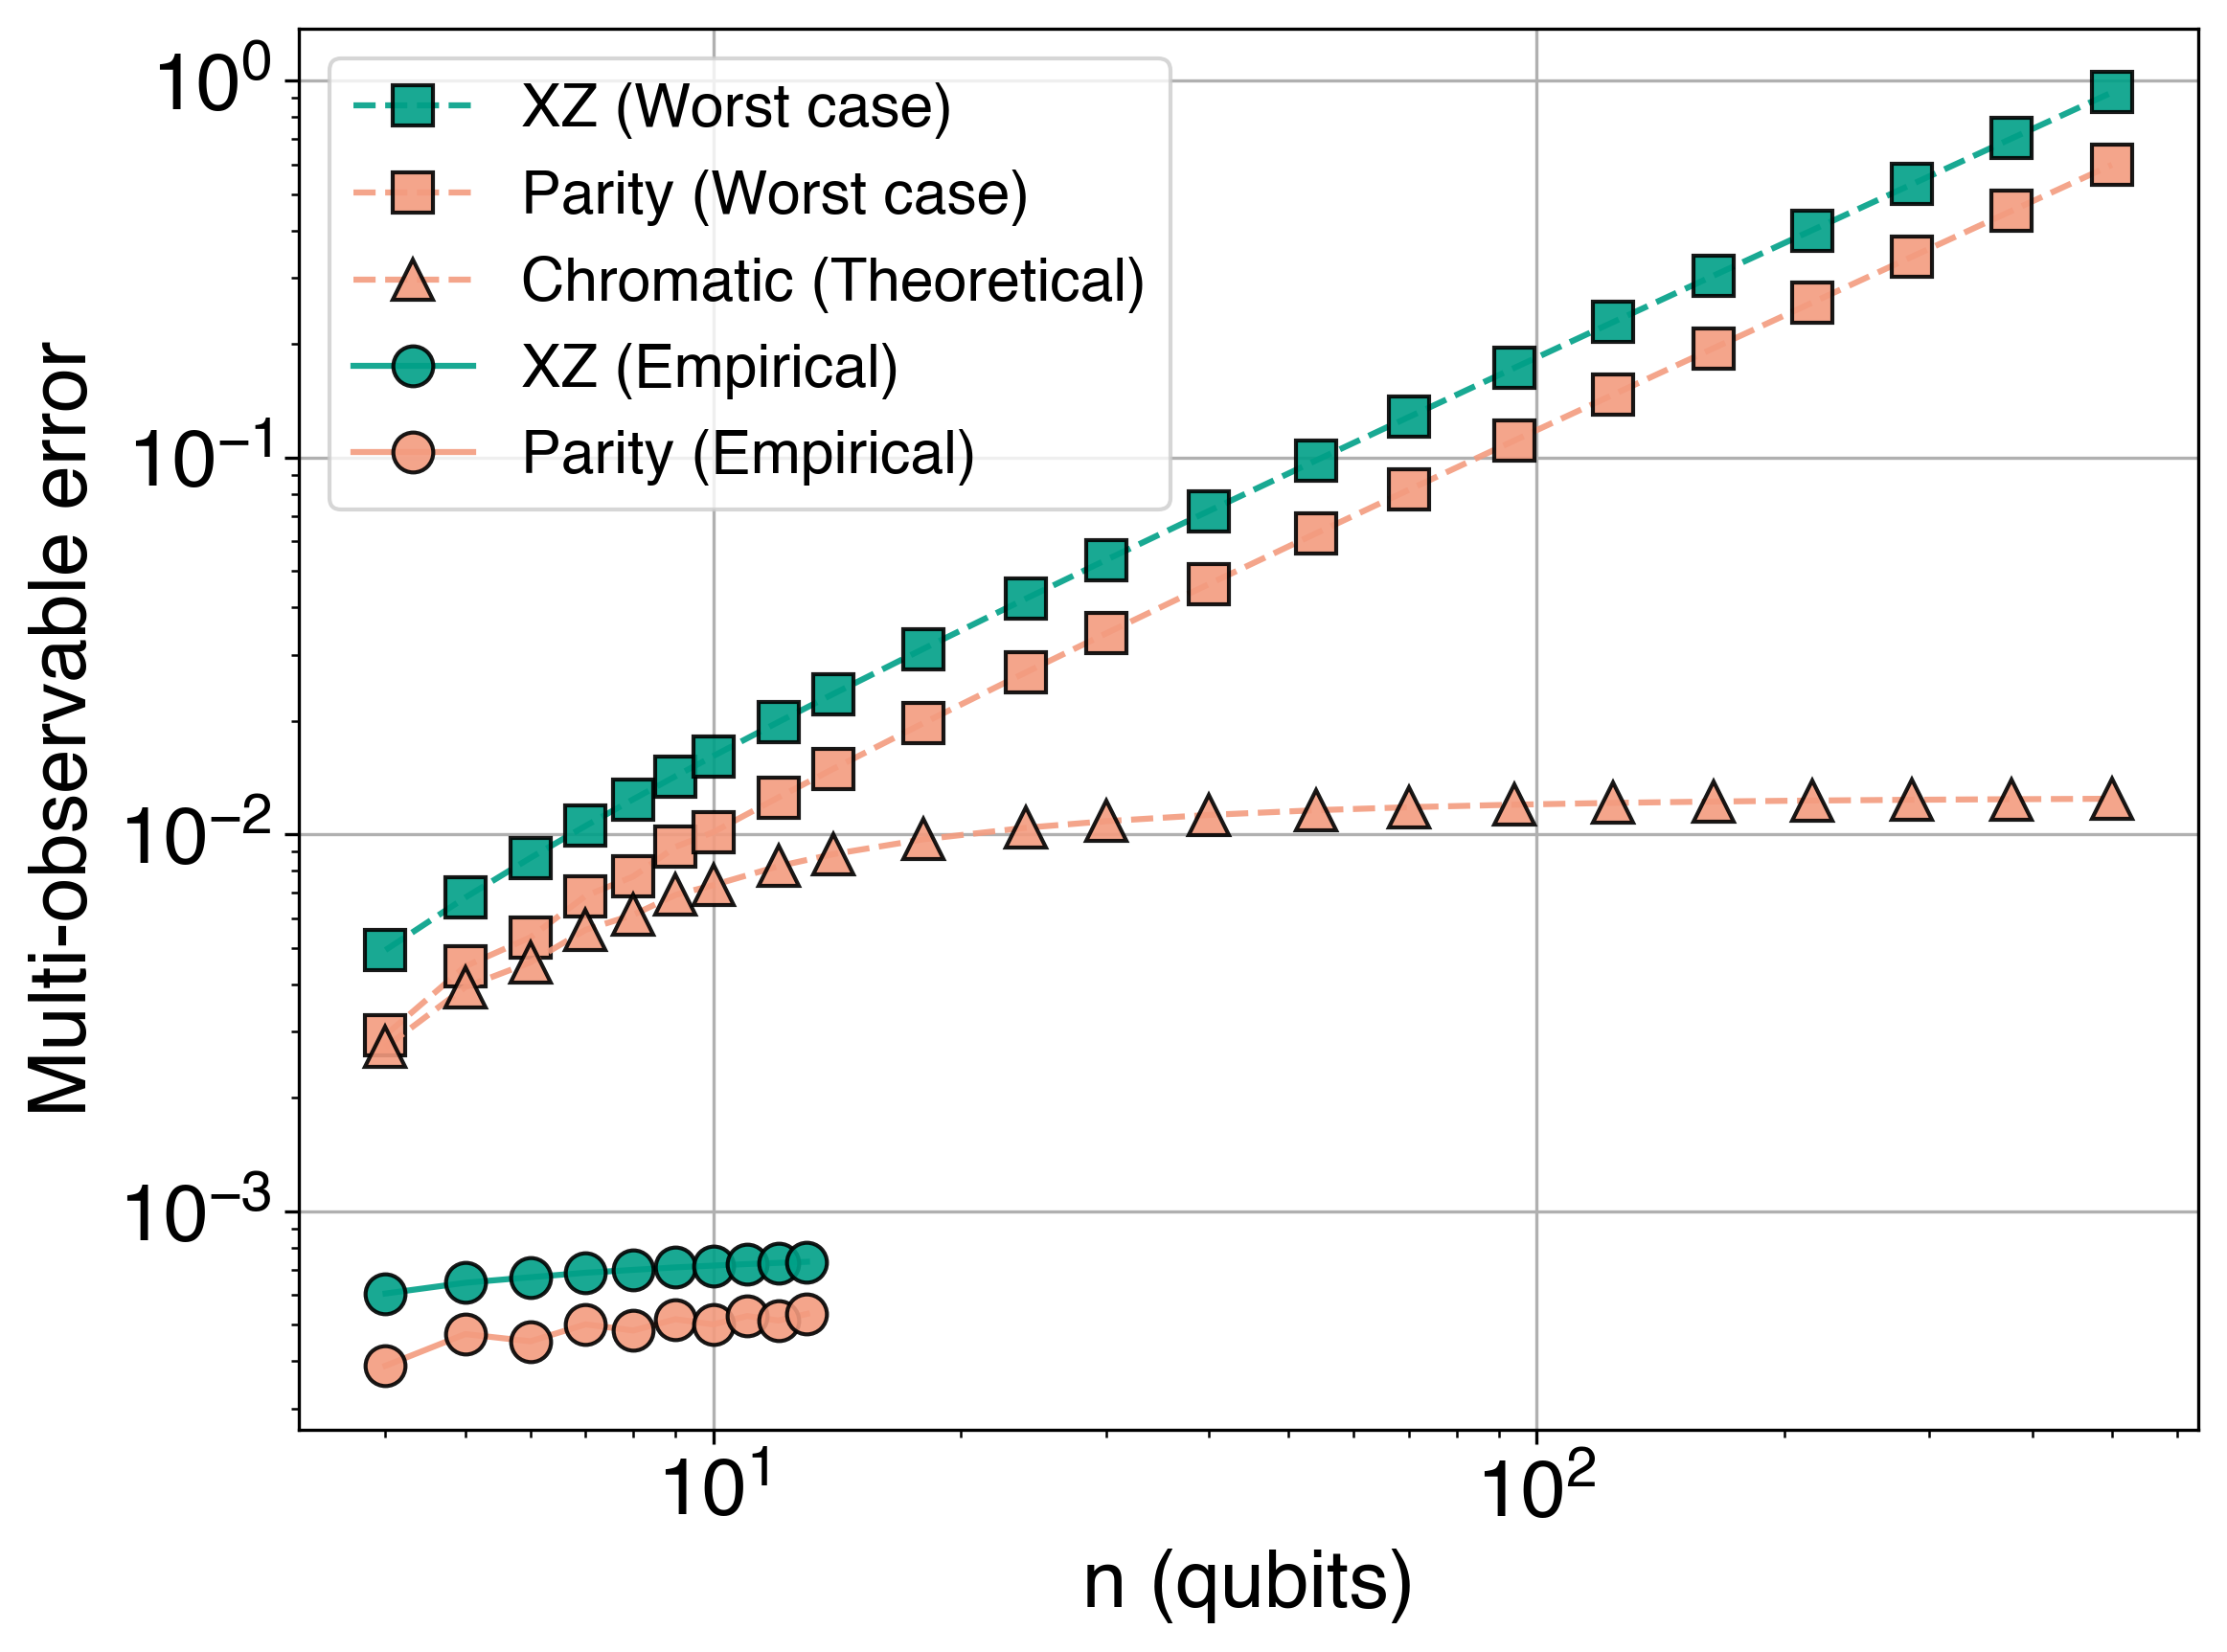

In [ ]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
# n = 8; 
t = 0.5
r = 5
# n_list = np.linspace(4, 500, 20, dtype=int)
n_list = [4, 5, 6, 7, 8, 9, 10, 12, 14,  18,  24,  30,  40,  54,  70,  94, 124, 164, 216, 286, 378, 500]
n_list_emp = range(4, 14)
data = {'error_xyz': [], 'error_parity': [], 'error_standard': [], 'error_xyz_emp': [], 'error_parity_emp': []}
print(f"J={J}, h={h}, t={t}, r={r}")
for n in n_list:
    error_xyz = analy_st_loose_bound(r, n, J, h, t, group='xyz')
    error_standard = analy_st_loose_bound(r, n, J, h, t, group='parity')
    error_parity = analy_lc_bound(r, n, J, h, t, ob_type='multi')
    data['error_xyz'].append(error_xyz)
    data['error_standard'].append(error_standard)
    data['error_parity'].append(error_parity)
    # print(f"n={n}, empirical error_xyz={error_xyz}, empirical error_parity={error_parity}")  

for n in n_list_emp:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    # z_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
    error_xyz = ob_error(magn_op, exact_U, appro_U_xyz)
    error_parity = ob_error(magn_op, exact_U, appro_U_parity)
    data['error_xyz_emp'].append(error_xyz)
    data['error_parity_emp'].append(error_parity)
    print(f"n={n}, empirical error_xyz={error_xyz:.6f}, empirical error_parity={error_parity:.6f}")  

fig, ax = plt.subplots(figsize=(8, 6), layout='tight')
ax.plot(n_list, data['error_xyz'], 's--', color='#00A087FF', label='XZ (Worst case)')
ax.plot(n_list, data['error_standard'], 's--', color='#F39B7FFF', label='Parity (Worst case)')
ax.plot(n_list, data['error_parity'], '^--', color='#F39B7FFF', label='Chromatic (Theoretical)')
ax.plot(n_list_emp, data['error_xyz_emp'], 'o-', color='#00A087FF', label='XZ (Empirical)')
ax.plot(n_list_emp, data['error_parity_emp'], 'o-', color='#F39B7FFF', label='Parity (Empirical)')
ax.loglog()
ax.set_xlabel('n (qubits)')
# ax.set_title(f't={t}, r={r}')
# ax.set_yscale('log')
ax.grid()
ax.set_ylabel('Multi-observable error')
ax.legend() 
fig.savefig(f'../figs/grouping_TFI1d_n={n}_Multi_t={t}.pdf', bbox_inches='tight')

J=1, h=0.2, t=0.5, r=30
n=8, empirical error_xyz=0.000019, empirical error_parity=0.000013
n=8, empirical error_xyz=0.000039, empirical error_parity=0.000027
n=8, empirical error_xyz=0.000062, empirical error_parity=0.000043
n=8, empirical error_xyz=0.000084, empirical error_parity=0.000060
n=8, empirical error_xyz=0.000101, empirical error_parity=0.000075
n=8, empirical error_xyz=0.000109, empirical error_parity=0.000101
n=8, empirical error_xyz=0.000113, empirical error_parity=0.000138
n=8, empirical error_xyz=0.000138, empirical error_parity=0.000184
n=8, empirical error_xyz=0.000207, empirical error_parity=0.000241
n=8, empirical error_xyz=0.000300, empirical error_parity=0.000309
n=8, empirical error_xyz=0.000399, empirical error_parity=0.000389
n=8, empirical error_xyz=0.000489, empirical error_parity=0.000479
n=8, empirical error_xyz=0.000559, empirical error_parity=0.000579
n=8, empirical error_xyz=0.000609, empirical error_parity=0.000688
n=8, empirical error_xyz=0.000661, emp

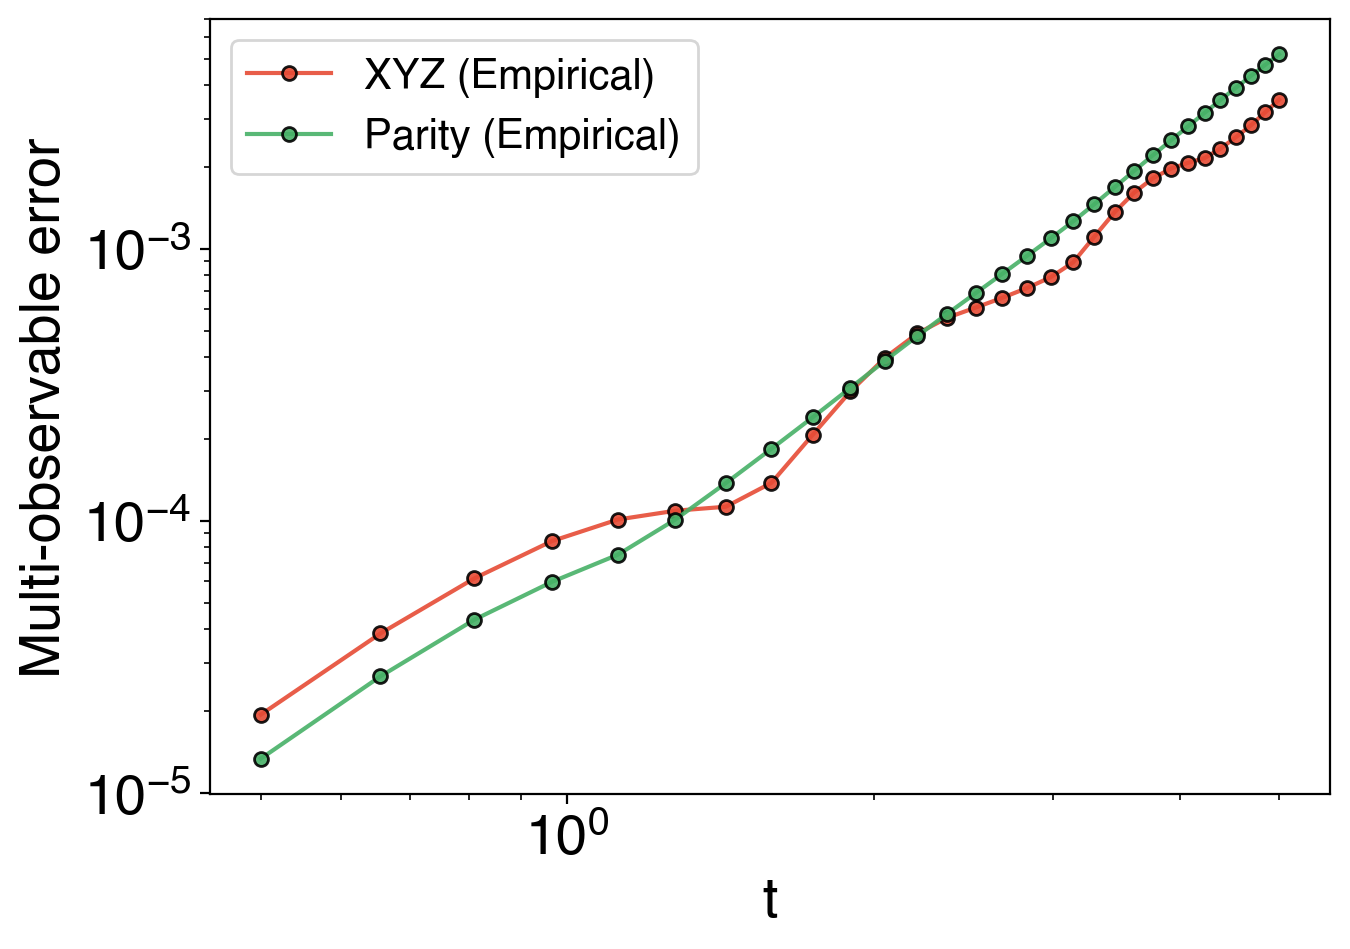

In [ ]:
from spin_ham import TF_Ising_1d
J=1; h=0.2; 
n = 8; 
r = 30
t = 0.5
t_list = np.linspace(0.5, 5, 30)
# n_list = range(4, 20)
# n_list_emp = range(4, 11)
data = {'error_xyz': [], 'error_parity': [], 'error_xyz_emp': [], 'error_parity_emp': []}
print(f"J={J}, h={h}, t={t}, r={r}")

for t in t_list:
    tfI = TF_Ising_1d(n, J, h)
    exact_U = expm(-1j * t * tfI.ham.to_matrix())
    appro_U_xyz = standard_trotter([h.to_matrix(True) for h in tfI.ham_xyz], t, r)
    appro_U_parity = standard_trotter([h.to_matrix(True) for h in tfI.ham_parity], t, r)
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n)/n
    # z_op = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n)
    error_xyz = ob_error(magn_op, exact_U, appro_U_xyz)
    error_parity = ob_error(magn_op, exact_U, appro_U_parity)
    data['error_xyz_emp'].append(error_xyz)
    data['error_parity_emp'].append(error_parity)
    print(f"n={n}, empirical error_xyz={error_xyz:.6f}, empirical error_parity={error_parity:.6f}")  

fig, ax = plt.subplots(figsize=(7, 5), layout='tight')
# ax.plot(n_list, data['error_xyz'], '.--', label='XYZ (Bound)')
# ax.plot(n_list, data['error_parity'], '.--', label='Parity (Bound)')
ax.plot(t_list, data['error_xyz_emp'], '.-', label='XYZ (Empirical)')
ax.plot(t_list, data['error_parity_emp'], '.-', label='Parity (Empirical)')
ax.loglog()
ax.set_xlabel('t')
# ax.set_yscale('log')
ax.set_ylabel('Multi-observable error')
ax.legend() 


### Main

--------------------------n=4----------------------------
=========pf_type=standard, ob_type=multi=========
r=10; error=0.000733; exp_count=160
r=5; error=0.002933; exp_count=80
r=3; error=0.008148; exp_count=48
r=4; error=0.004583; exp_count=64
-------- binary search end --------
=========pf_type=lightcone, ob_type=multi=========
r=10; error=0.000708; exp_count=160
r=5; error=0.002727; exp_count=80
r=3; error=0.007191; exp_count=48
r=4; error=0.004180; exp_count=64
-------- binary search end --------
standard: error=0.004583; exp_count=32
lightcone: error=0.004180; exp_count=51
=========pf_type=lightcone, ob_type=single=========
r=10; error=0.000673; exp_count=147
r=5; error=0.002453; exp_count=67
r=3; error=0.005926; exp_count=35
r=4; error=0.003646; exp_count=51
-------- binary search end --------
lightcone: error=0.005926; exp_count=35
--------------------------n=5----------------------------
=========pf_type=standard, ob_type=multi=========
r=13; error=0.000661; exp_count=260
r=7;

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


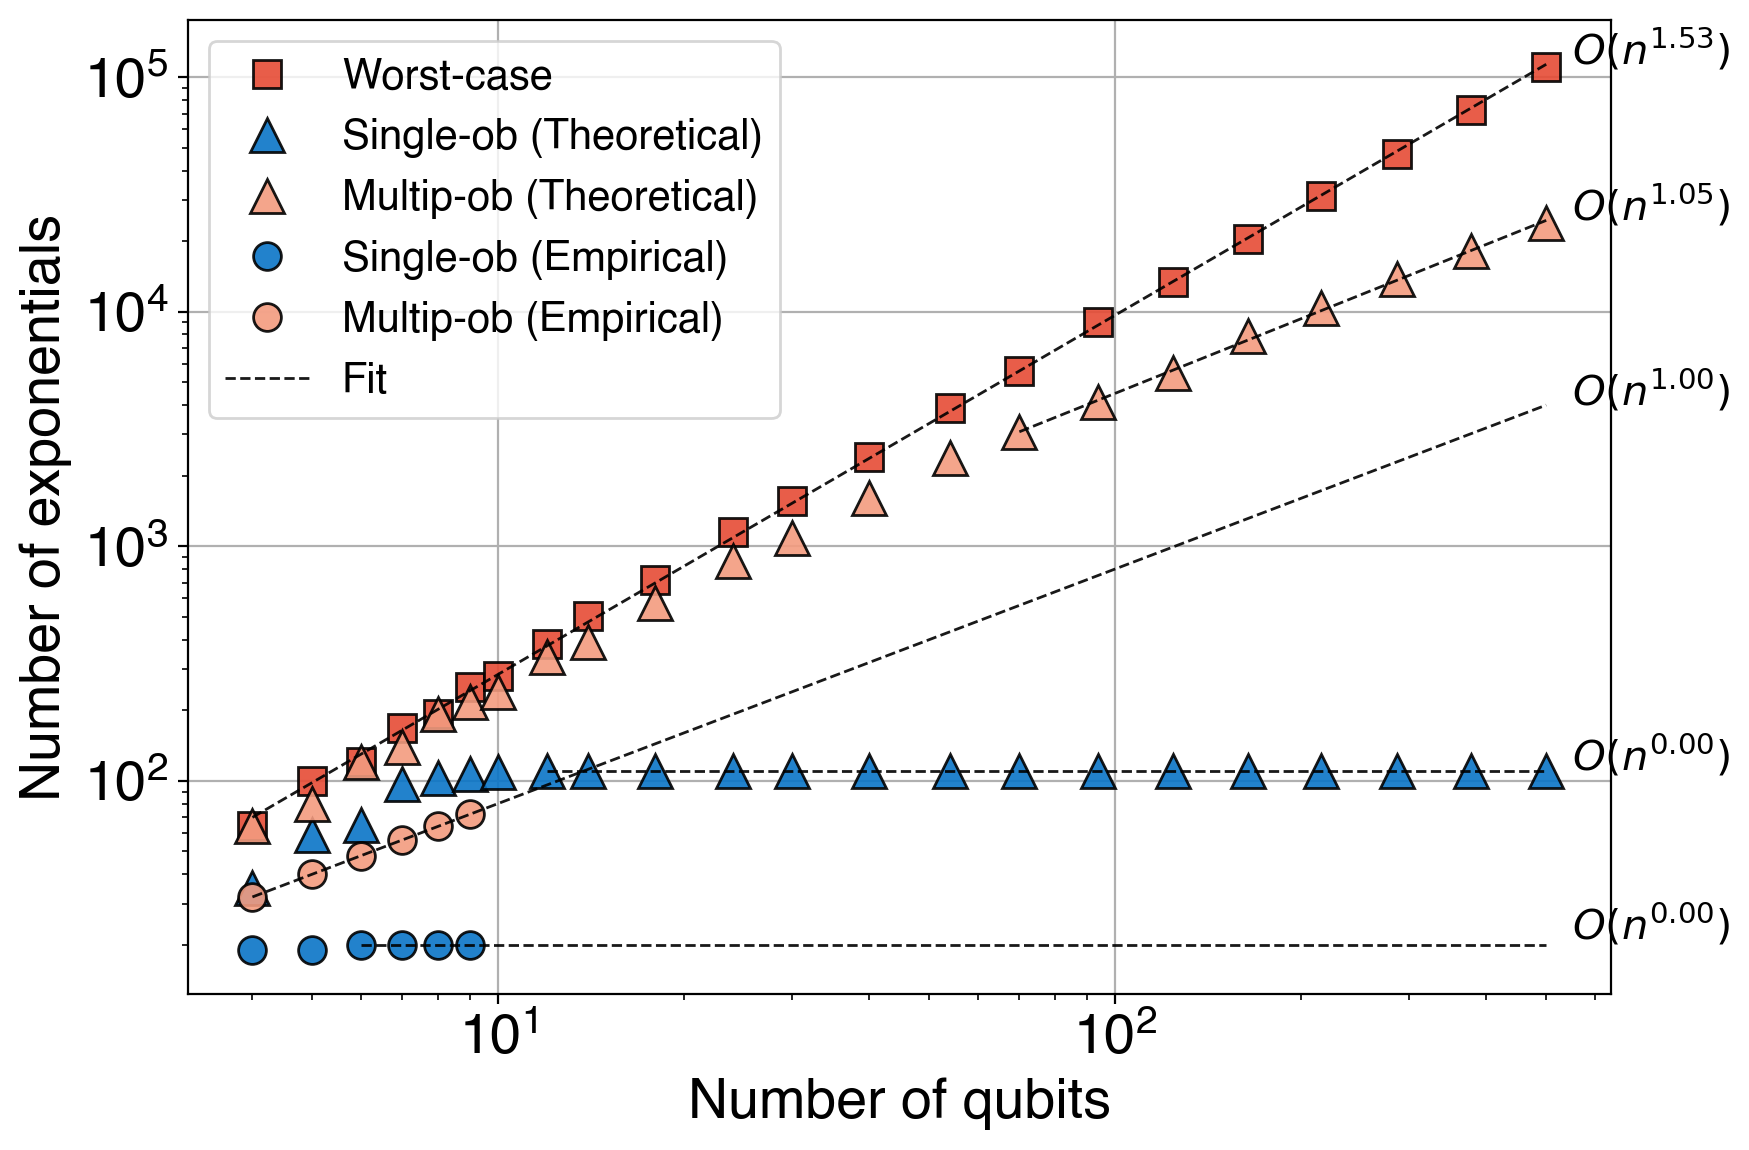

In [2]:
from lightcone import *
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
# n_list = [7, 8, 9, 10]
# n_list = range(4, 200, 5)
# n_list = np.array(sorted(list(set(np.logspace(0.65, 2.5, 30, dtype=int)))))
n_list = [4, 5, 6, 7, 8, 9, 10, 12, 14,  18,  24,  30,  40,  54,  70,  94, 124, 164, 216, 286, 378, 500]
# n_list = [4, 5, 6, 7, 8, 9, 10, 12,  16,  20,  26,  34,  43,  56,  71,  92, 117, 150, 193, 247, 316]
# n_list = np.array(sorted(list(set(np.logspace(0.65, 3.0, 40, dtype=int)))))
# n_list = np.logspace(0.6, 2.3, 40, dtype=int)    
# n_list = range(4, 150, 3)
n_list_emp = range(4, 10, 1)
# st_r_bound_n, st_cost_bound_n, lc_r_bound_n, lc_cost_bound_n, em_r_bound_n, em_cost_bound_n = [], [], [], [], [], []
ob_index = [0]
# t = 1.0
t = 0.5
J=1; h=0.2
# J=1/2; h=1/2
ob_type = 'multi'
epsilon=0.005; search_precision=0.02
r_st_found_list, r_lc_found_list, cost_st_found_list, cost_lc_found_list, r_em_found_list, cost_em_found_list = [], [], [], [], [], []
r_lc_found_list_s, cost_lc_found_list_s, r_em_found_list_s, cost_em_found_list_s = [], [], [], []
for n in n_list:
    print(f'--------------------------n={n}----------------------------')
    # ob, ob_dict = local_ob(ob_index, n)
    # ising1d_n_bd = transverse_field_ising_1d(n, J, h, ob_index, t=t, initialize=True, verbose=verbose)
    # print(ising1d_n_bd.all_terms)
    # print(2 * tight_bound([h.to_matrix() for h in ising1d_n_bd.all_terms], 2, t, 1))
    # print('========== STANDARD Bound ==========')
    r_list_st, error_list_st, exp_count_list_st, r_found_st, r_err_dict_st = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='standard', ob_type='multi', verbose=True)
    r_list_lc, error_list_lc, exp_count_list_lc, r_found_lc, r_err_dict_lc = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='lightcone', ob_type='multi', verbose=True)
    print(f'standard: error={r_err_dict_st[r_found_st]:.6f}; exp_count={ 2 * n * r_found_st}')
    print(f'lightcone: error={r_err_dict_lc[r_found_lc]:.6f}; exp_count={exp_count_LC(r_found_lc, n, 2*n)}')
    r_st_found_list.append(r_found_st)
    r_lc_found_list.append(r_found_lc)
    cost_st_found_list.append(2 * (2*n) * r_found_st)
    cost_lc_found_list.append(2 * (2*n) * r_found_lc)

    # print('========== LIGHTCONE Bound ==========')
    r_list_lc_s, error_list_lc_s, exp_count_list_lc_s, r_found_lc_s, r_err_dict_lc_s = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='lightcone', verbose=True)
    print(f'lightcone: error={r_err_dict_lc_s[r_found_lc_s]:.6f}; exp_count={exp_count_LC(r_found_lc_s, n, 2*n)}')
    r_lc_found_list_s.append(r_found_lc_s)
    cost_lc_found_list_s.append(exp_count_LC(r_found_lc_s, n, 2*n))
    # cost_lc_found_list.append(exp_count_LC(r_found_lc, n, 2*n))

    # _, _, _, r_bound = binary_search_r(ising1d_n, ob, t, epsilon, search_precision, type='bound', verbose=True)
    # st_r_bound_n.append(r_bound)
    # st_cost_bound_n.append(r_bound*2*ising1d_n.n_terms)
for n in n_list_emp:
    print(f'========== EMPIRICAL n={n}==========')
    r_list_em, error_list_em, exp_count_list_em, r_found_em, r_err_dict_em = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='empirical', ob_type='multi', verbose=True)
    print(f'empirical: error={r_err_dict_em[r_found_em]:.6f}; exp_count={ 2 * n * r_found_em}')
    r_em_found_list.append(r_found_em)
    cost_em_found_list.append(2 * (2*n) * r_found_em)

    r_list_em_s, error_list_em_s, exp_count_list_em_s, r_found_em_s, r_err_dict_em_s = bin_search_r(n, J, h, t, epsilon, search_precision, pf_type='empirical', ob_type='single', verbose=True)
    # print(f'empirical: error={r_err_dict_em[r_found_em]:.6f}; exp_count={ 2 * n * r_found_em}')
    # r_em_found_list.append(r_found_em)
    # cost_em_found_list.append(2 * (2*n) * r_found_em)
    cost_em_found_list_s.append(exp_count_LC(r_found_em, n, 2*n))
    # cost_em_found_list_s.append(exp_count_list_em_s[-1])

fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
ob_string = 'XIII'
ax2.plot(n_list, cost_st_found_list, 's', color='#E64B35FF', label=r'Worst-case', markersize=10)
# ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list, cost_lc_found_list_s, '^', color='#0A75C7', label='Single-ob (Theoretical)', markersize=12)
ax2.plot(n_list, cost_lc_found_list, '^', color='#F39B7FFF', label='Multip-ob (Theoretical)', markersize=12)
ax2.plot(n_list_emp, cost_em_found_list_s, 'o', color='#0A75C7', label='Single-ob (Empirical)')
ax2.plot(n_list_emp, cost_em_found_list, 'o', color='#F39B7FFF', label='Multip-ob (Empirical)')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'ob=$\sum Z_j/n$, TFI (fix t={t}, $\epsilon$={epsilon}) PF2')  

ax2.xaxis.set_major_formatter(formatter)
# ax2.set_yscale('log')
# ax2.set_xscale('log')

y_pred_st, a_st, b_st = linear_loglog_fit(n_list, cost_st_found_list)
ax2.plot(n_list, y_pred_st, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % str(a_st)[:4], xy=(n_list[-1], np.real(y_pred_st)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_st)[-1]+1))

perc= 3/2.0
# perc= 3/2.2
# perc= 3/2.5
print(n_list[int(len(n_list)/perc)])
y_pred_lc, a_lc, b_lc = linear_loglog_fit(n_list[int(len(n_list)/perc):], cost_lc_found_list[int(len(n_list)/perc):])
ax2.plot(n_list[int(len(n_list)/perc):], y_pred_lc, 'k--', label='Fit', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % str(a_lc)[:4], xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))

# multip-ob empirical
y_pred_em, a_em, b_em = linear_loglog_fit(n_list_emp, cost_em_found_list)
print(f'a_em: {a_em}; b_em: {b_em}')
text_a_em = "{:.2f}".format(round(abs(a_em), 4))
y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in n_list])+b_em]
ax2.plot(n_list, y_pred_em, 'k--', linewidth=1)
# ax2.plot(n_list_emp, y_pred_em, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % text_a_em, xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))

# single-ob empirical
y_pred_em, a_em, b_em = linear_loglog_fit(n_list_emp[3:], cost_em_found_list_s[3:])
print(f'a_em: {a_em}; b_em: {b_em}')
text_a_em = "{:.2f}".format(round(abs(a_em), 4))
y_pred_em = [exp(cost) for cost in a_em*np.array([log(n) for n in n_list])+b_em]
ax2.plot(n_list[2:], y_pred_em[2:], 'k--', linewidth=1)
# ax2.plot(n_list_emp, y_pred_em, 'k--', linewidth=1)
ax2.annotate(r'$O(n^{%s})$' % text_a_em, xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))
# ax2.annotate(r'$O(n^{%s})$' % str(round(abs(a_em), 4))[:4], xy=(n_list_emp[-1], np.real(y_pred_em)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_em)[-1]+1))

# single-ob bound
perc= 3
y_pred_lc, a_lc, b_lc = linear_loglog_fit(n_list[int(len(n_list)/perc):], cost_lc_found_list_s[int(len(n_list)/perc):])
text_a_lc = "{:.2f}".format(round(abs(a_lc), 4))
ax2.plot(n_list[int(len(n_list)/perc):], y_pred_lc, 'k--', linewidth=1)
# ax2.annotate(r'$O(n^{%s})$' % text_a_lc, xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))
ax2.annotate(r'$O(n^{%s})$' % text_a_lc, xy=(n_list[-1], np.real(y_pred_lc)[-1]), xytext=(n_list[-1]*1.1, np.real(y_pred_lc)[-1]+1))
# ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.loglog()

# ax2.set_xticks(range(int(min(n_list)), int(max(n_list)) + 1))
# plt.title('Two Lines with Intersection Point')
ax2.legend()
ax2.grid()
# fig.savefig(f'../figs/lightcone_TFI1d_n={n}_eps={epsilon}_Bound_costVSn_multiOB_t={t}.pdf')
fig.savefig(f'./figs/lightcone_TFI1d_n={n}_eps={epsilon}_SingleMulti_t={t}.pdf', bbox_inches='tight')

In [ ]:
analy_lc_bound(3, 500, J, h, t)

NameError: name 'J' is not defined

### Bounds (tight, loose)

In [ ]:
from lattice_hamiltonians import heisenberg_1d
n = 4; is_pbc = True; J = 1; h = 1
ising_bd = transverse_field_ising_1d(n, J, h, [1], 4, pbc=is_pbc, verbose=False)
# ising_bd = heisenberg_1d(2, 1, 1, 1, 2, verbose=False)
ising_bd.H_parity
h_list = ising_bd.all_terms

print('all terms: ', h_list)
commutator_bound(h_list, 2, 1, 1, type='tight')
commutator_bound(h_list, 2, 1, 1,type='loose')
tight_err = tight_bound([h.to_matrix() for h in h_list], 2, 1, 1)
print('tight_err: ', tight_err)
print('tight bound (parity): ', tight_bound(ising_bd.H_parity, 2, 1, 1))
print('analytic loose error:', analytic_loose_commutator_bound(n, J, h, 1, pbc=is_pbc))
print('tight bound (parity) first: ', tight_bound(ising_bd.H_parity, 1, 1, 1))
print('tight bound (all) first: ', tight_bound([h.to_matrix() for h in h_list], 1, 1, 1))

---------------------initialization start---------------------
----expm: exact U evaluated (t=4)----
single local observabel: {'X': [1]}
observable:  SparsePauliOp(['XIII'],
              coeffs=[1.+0.j])
evaluation: standard error bound
c1 (analy)=56, c2=24
evaluation: lightcone decompose
evalution: lightcone error bound
c1 (analy)=36, c2=16
c1 (analy)=56, c2=24
[['IXII', 'IZZI', 'ZZII', 'IIIX'], ['IIXI', 'IIZZ', 'XIII', 'ZIIZ']]
---------------------initialization done---------------------
all terms:  [SparsePauliOp(['ZZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['ZIIZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['XIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IXII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIXI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIX'],
              coeffs=[1.+0.j])]
c1 (tight)=69.20225231898308, c2=32.0
tigh

In [ ]:
# print(h_list)
# norm(commutator(ising_bd.H_parity[0], ising_bd.H_parity[1]))
print(commutator(ising_bd.even_op, ising_bd.odd_op).simplify())
print(norm(commutator(ising_bd.even_op, ising_bd.odd_op).simplify()))
norm(SparsePauliOp(['ZYII', 'IIZY', 'YIIZ', 'IZYI'], coeffs=[4j, 4j, -4j, -4j]))/2

SparsePauliOp(['ZYII', 'IIZY', 'YIIZ', 'IZYI'],
              coeffs=[0.+4.j, 0.+4.j, 0.-4.j, 0.-4.j])
11.313708498984761


5.656854249492381

In [ ]:
lightcone_bound_simplified(ising1d, 9, verbose=True)
lightcone_bound_simplified(ising1d, ising1d.r_saturate, verbose=True)

bound list:  [0.000177 0.000395 0.000618 0.000841]
bound list:  [0.001031 0.002305 0.003602 0.004906]


0.016750620270343665